# Getting Started with Binance - EMAs Analysis & Streamlit App Creation

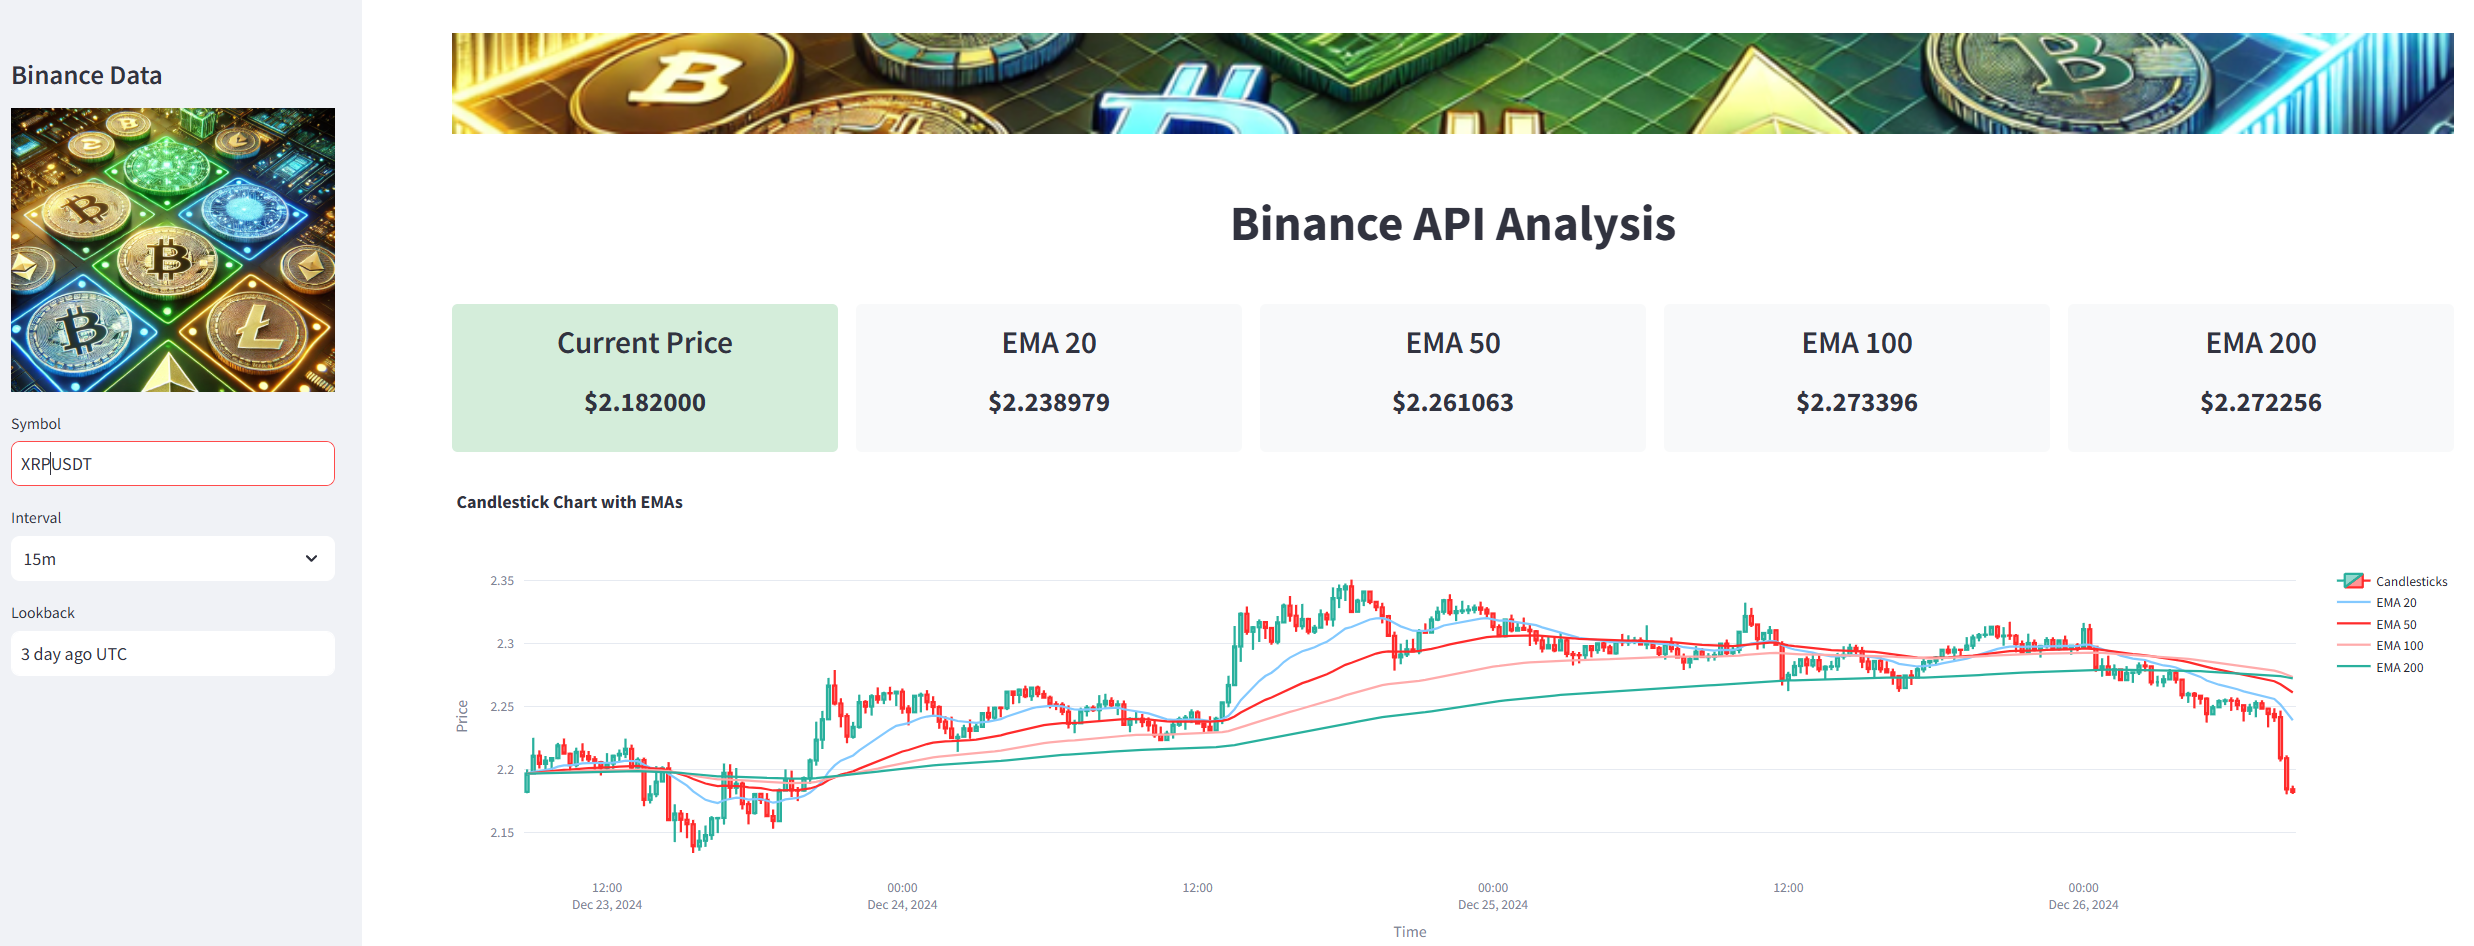

In [1]:
import os
from IPython.display import Image
Image("Pic3.png",width=900, height=700)

## Agenda:
- Connect to Binance
- Pull Data
- EMAs Analysis
- Plotting
- Streamlit App

### Step 1 - Connect to Binance 

In [14]:
# pip install python-binance
# Then Restart Kernel

In [20]:
# Creating the connection
import pandas as pd
import numpy as np
from binance.client import Client
import plotly.graph_objects as go

# Binance API credentials
api_key = ''
api_secret = ''

# Initialize Binance client
client = Client(api_key, api_secret)

### Step 2 - Funtion to pull data

In [22]:
def get_historical_klines(symbol, interval, lookback):
    """
    Fetch historical klines (candlestick) data from Binance.

    :param symbol: Trading pair symbol (e.g., 'BTCUSDT')
    :param interval: Timeframe for candlesticks (e.g., '1h', '1d')
    :param lookback: Lookback period (e.g., '1 day ago UTC')
    :return: Pandas DataFrame with OHLCV data
    """
    try:
        klines = client.get_historical_klines(symbol, interval, lookback)
        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume', 
            'close_time', 'quote_asset_volume', 'number_of_trades', 
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.astype(float)
        return df
    except Exception as e:
        raise Exception(f"Error fetching data: {e}")

In [24]:
# Example usage
symbol = 'BTCUSDT'  # Trading pair symbol
interval = '15m'  # Time interval (e.g., '1h', '1d')
lookback = '1 day ago UTC'  # Lookback period

# Fetch data
df = get_historical_klines(symbol, interval, lookback)
df.head()

open      high       low     close     volume
timestamp                                                             
2024-12-27 10:00:00  96774.14  96927.72  96724.93  96744.29  131.15351
2024-12-27 10:15:00  96744.30  97029.25  96479.09  96585.34  212.64864
2024-12-27 10:30:00  96585.34  96649.43  96195.20  96433.89  229.76336
2024-12-27 10:45:00  96433.89  96656.62  96356.37  96605.46  158.51024
2024-12-27 11:00:00  96605.46  96656.63  96441.77  96597.79  119.18518

### Step 3 - Adding EMAs

#### Exponential Moving Averages (EMAs) are a type of moving average used in technical analysis to smooth out price data and identify trends. Unlike a simple moving average, EMAs give more weight to recent prices, making them more responsive to new data.

#### Explanation of EMAs with Periods (e.g., 20-50-100):

- EMA-20 (Short-term):
    - Calculated over the last 20 periods.
    - Reacts quickly to price changes.
    - Commonly used to identify short-term trends.
- EMA-50 (Medium-term):
    - Calculated over the last 50 periods.
    - Less sensitive than the EMA-20 but smoother.
    - Often used to assess medium-term trends.
- EMA-100 (Long-term):
    - Calculated over the last 100 periods.
    - Even smoother and less reactive to short-term fluctuations.
    - Useful for identifying long-term trends.
  
#### How They Work Together:
- Crossovers: When a shorter EMA crosses above a longer EMA, it signals a potential uptrend (bullish crossover). The opposite signals a potential downtrend (bearish crossover).
- Trend Confirmation: If prices consistently stay above a particular EMA (e.g., EMA-50 or EMA-100), it can confirm a sustained uptrend.
- Support and Resistance: EMAs often act as dynamic support or resistance levels where prices tend to bounce or consolidate.
  
By combining multiple EMAs (e.g., 20-50-100), traders get a comprehensive view of short, medium, and long-term market trends.

In [27]:
def add_ema(df, periods=[20, 50, 100, 200]):
    """
    Add Exponential Moving Averages (EMAs) to the DataFrame.

    :param df: DataFrame with price data
    :param periods: List of periods for EMAs
    :return: DataFrame with added EMA columns
    """
    for period in periods:
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    return df

In [29]:
df = add_ema(df)
df.head()

open      high       low     close     volume  \
timestamp                                                                
2024-12-27 10:00:00  96774.14  96927.72  96724.93  96744.29  131.15351   
2024-12-27 10:15:00  96744.30  97029.25  96479.09  96585.34  212.64864   
2024-12-27 10:30:00  96585.34  96649.43  96195.20  96433.89  229.76336   
2024-12-27 10:45:00  96433.89  96656.62  96356.37  96605.46  158.51024   
2024-12-27 11:00:00  96605.46  96656.63  96441.77  96597.79  119.18518   

                           EMA_20        EMA_50       EMA_100       EMA_200  
timestamp                                                                    
2024-12-27 10:00:00  96744.290000  96744.290000  96744.290000  96744.290000  
2024-12-27 10:15:00  96729.151905  96738.056667  96741.142475  96742.708408  
2024-12-27 10:30:00  96701.031723  96726.128562  96735.058268  96739.635588  
2024-12-27 10:45:00  96691.929654  96721.396462  96732.491965  96738.300508  
2024-12-27 11:00:00  96682.963973  96716.549149  96729.824600  96736.902393

### Step 4 - Plotting

In [31]:
def plot_data_with_ema(df):
    """
    Create an interactive Plotly plot with candlestick data and EMAs.

    :param df: DataFrame with price and EMA data
    """
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Candlesticks'
    ))

    # Add EMAs
    for ema_period in [20, 50, 100, 200]:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[f'EMA_{ema_period}'],
            mode='lines',
            name=f'EMA {ema_period}'
        ))

    # Customize layout
    fig.update_layout(
        title="Candlestick Chart with EMAs",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False
    )

    fig.show()

In [33]:
plot_data_with_ema(df)

### Step 5 - Streamlit App

In [43]:
import streamlit as st
import pandas as pd
import numpy as np
from binance.client import Client
import plotly.graph_objects as go
from PIL import Image

# Binance API credentials
API_KEY = ''
API_SECRET = ''

# Initialize Binance client
client = Client(API_KEY, API_SECRET)

def get_historical_klines(symbol, interval, lookback):
    """
    Fetch historical klines (candlestick) data from Binance.

    :param symbol: Trading pair symbol (e.g., 'BTCUSDT')
    :param interval: Timeframe for candlesticks (e.g., '1h', '1d')
    :param lookback: Lookback period (e.g., '1 day ago UTC')
    :return: Pandas DataFrame with OHLCV data
    """
    try:
        klines = client.get_historical_klines(symbol, interval, lookback)
        df = pd.DataFrame(klines, columns=[
            'timestamp', 'open', 'high', 'low', 'close', 'volume', 
            'close_time', 'quote_asset_volume', 'number_of_trades', 
            'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
        ])
        df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        df = df.astype(float)
        return df
    except Exception as e:
        raise Exception(f"Error fetching data: {e}")

def add_ema(df, periods=[20, 50, 100, 200]):
    """
    Add Exponential Moving Averages (EMAs) to the DataFrame.

    :param df: DataFrame with price data
    :param periods: List of periods for EMAs
    :return: DataFrame with added EMA columns
    """
    for period in periods:
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
    return df

def plot_data_with_ema(df):
    """
    Create an interactive Plotly plot with candlestick data and EMAs.

    :param df: DataFrame with price and EMA data
    """
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Candlesticks'
    ))

    # Add EMAs
    for ema_period in [20, 50, 100, 200]:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[f'EMA_{ema_period}'],
            mode='lines',
            name=f'EMA {ema_period}'
        ))

    # Customize layout
    fig.update_layout(
        title="Candlestick Chart with EMAs",
        xaxis_title="Time",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False
    )

    st.plotly_chart(fig, use_container_width=True)

# Streamlit layout
st.set_page_config(layout="wide")

# Sidebar setup
st.sidebar.title("Binance Data")
image_sidebar = Image.open("Pic1.png")  # Sidebar image
st.sidebar.image(image_sidebar, use_column_width=True)

symbol = st.sidebar.text_input("Symbol", "BTCUSDT")
interval = st.sidebar.selectbox("Interval", options=["1m", "5m", "15m", "1h", "4h", "1d"], index=3)
lookback = st.sidebar.text_input("Lookback", "1 day ago UTC")

# Main page setup
image_main = Image.open("Pic2.png")  # Main page image
st.image(image_main, use_column_width=True)

# Remove extra space at the top
st.markdown("<style> .css-18e3th9 { padding-top: 0; } </style>", unsafe_allow_html=True)

# Fetch and process data
try:
    df = get_historical_klines(symbol, interval, lookback)
    df = add_ema(df)

    # Main Title
    st.markdown("<h1 style='text-align: center; margin-bottom: 30px;'>Binance API Analysis</h1>", unsafe_allow_html=True)

    # Get current symbol price and latest EMAs
    current_price = df['close'].iloc[-1]
    ema_20 = df['EMA_20'].iloc[-1]
    ema_50 = df['EMA_50'].iloc[-1]
    ema_100 = df['EMA_100'].iloc[-1]
    ema_200 = df['EMA_200'].iloc[-1]

    # Display metrics in columns
    col1, col2, col3, col4, col5 = st.columns(5)

    with col1:
        st.markdown(
            f"""
            <div style="background-color: #d4edda; padding: 10px; border-radius: 5px; text-align: center;">
                <h3>Current Price</h3>
                <p style="font-size: 24px; font-weight: bold;">${current_price:,.6f}</p>
            </div>
            """,
            unsafe_allow_html=True,
        )

    with col2:
        st.markdown(
            f"""
            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                <h3>EMA 20</h3>
                <p style="font-size: 24px; font-weight: bold;">${ema_20:,.6f}</p>
            </div>
            """,
            unsafe_allow_html=True,
        )

    with col3:
        st.markdown(
            f"""
            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                <h3>EMA 50</h3>
                <p style="font-size: 24px; font-weight: bold;">${ema_50:,.6f}</p>
            </div>
            """,
            unsafe_allow_html=True,
        )

    with col4:
        st.markdown(
            f"""
            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                <h3>EMA 100</h3>
                <p style="font-size: 24px; font-weight: bold;">${ema_100:,.6f}</p>
            </div>
            """,
            unsafe_allow_html=True,
        )

    with col5:
        st.markdown(
            f"""
            <div style="background-color: #f8f9fa; padding: 10px; border-radius: 5px; text-align: center;">
                <h3>EMA 200</h3>
                <p style="font-size: 24px; font-weight: bold;">${ema_200:,.6f}</p>
            </div>
            """,
            unsafe_allow_html=True,
        )

    # Plot chart below metrics
    plot_data_with_ema(df)

except Exception as e:
    st.error(f"Error: {e}")

# Streamlit run Binance_EMAs.py

2024-12-26 08:34:14.941 
  command:

    streamlit run Y:\Python\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
